<a href="https://colab.research.google.com/github/ZahraReyhanian/DGM/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

If you want to write your own code and not follow this format, it is ok. Just make sure to use the same hyperparameters and models. If you see convergence sooner during the training, you may use fewer iterations.

In [ ]:
import argparse
import numpy as np
from tqdm import tqdm
from pprint import pprint
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
from torch import autograd, nn, optim
from torch.distributions.normal import Normal
from sklearn.preprocessing import StandardScaler

# Latent dimensions
z = 10
# Training iterations
iter_max = 200
# Batch size
batch_size = 100
# For the optimizer
learning_rate = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Load dataset

In [ ]:
def get_mnist_data(device, batch_size):
    preprocess = transforms.ToTensor()
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)

    # Create pre-processed training and test sets
    X_train = train_loader.dataset.train_data.to(device).reshape(-1, 784).float() / 255
    y_train = train_loader.dataset.train_labels.to(device)
    X_test = test_loader.dataset.test_data.to(device).reshape(-1, 784).float() / 255
    y_test = test_loader.dataset.test_labels.to(device)

    return train_loader, test_loader

train_loader, test_loader = get_mnist_data(device, batch_size)
train_loader

100%|██████████| 9912422/9912422 [00:00<00:00, 101427180.42it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 44931637.18it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27170582.54it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12794176.47it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### Utility Functions
- Complete the code for the function ```sample_gaussian```

In [ ]:
def gaussian_parameters(h, dim=-1):
    """
    Converts generic real-valued representations into mean and variance
    parameters of a Gaussian distribution

    Args:
        h: tensor: (batch, ..., dim, ...): Arbitrary tensor
        dim: int: (): Dimension along which to split the tensor for mean and
            variance

    Returns:
        m: tensor: (batch, ..., dim / 2, ...): Mean
        v: tensor: (batch, ..., dim / 2, ...): Variance
    """
    m, h = torch.split(h, h.size(dim) // 2, dim=dim)
    v = F.softplus(h) + 1e-8
    return m, v


def sample_gaussian(m, v):
    """
    Element-wise application reparameterization trick to sample from Gaussian

    Args:
        m: tensor: (batch, ...): Mean
        v: tensor: (batch, ...): Variance

    Return:
        z: tensor: (batch, ...): Samples
    """
    batch, dim = m.shape

    std = torch.sqrt(v)
    eps = Normal(0, 1).sample((batch, dim)).to(m.device)
    zy =  m + eps * std

    return zy


bce = torch.nn.BCEWithLogitsLoss(reduction='none')


def log_bernoulli_with_logits(x, logits):
    """
    Computes the log probability of a Bernoulli given its logits

    Args:
        x: tensor: (batch, dim): Observation
        logits: tensor: (batch, dim): Bernoulli logits

    Return:
        log_prob: tensor: (batch,): log probability of each sample
    """
    log_prob = -bce(input=logits, target=x).sum(-1)
    return log_prob


def kl_normal(qm, qv, pm, pv):
    """
    Computes the elem-wise KL divergence between two normal distributions KL(q || p) and
    sum over the last dimension

    Args:
        qm: tensor: (batch, dim): q mean
        qv: tensor: (batch, dim): q variance
        pm: tensor: (batch, dim): p mean
        pv: tensor: (batch, dim): p variance

    Return:
        kl: tensor: (batch,): kl between each sample
    """
    element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)
    kl = element_wise.sum(-1)
    return kl

def duplicate(x, rep):
    """
    Duplicates x along dim=0

    Args:
        x: tensor: (batch, ...): Arbitrary tensor
        rep: int: (): Number of replicates. Setting rep=1 returns orignal x

    Returns:
        _: tensor: (batch * rep, ...): Arbitrary replicated tensor
    """
    return x.expand(rep, *x.shape).reshape(-1, *x.shape[1:])

def log_normal(x, m, v):
    """
    Computes the elem-wise log probability of a Gaussian and then sum over the
    last dim. Basically we're assuming all dims are batch dims except for the
    last dim.

    Args:
        x: tensor: (batch_1, batch_2, ..., batch_k, dim): Observation
        m: tensor: (batch_1, batch_2, ..., batch_k, dim): Mean
        v: tensor: (batch_1, batch_2, ..., batch_k, dim): Variance

    Return:
        log_prob: tensor: (batch_1, batch_2, ..., batch_k): log probability of
            each sample. Note that the summation dimension is not kept
    """
    log_std = torch.log(torch.sqrt(v))
    log_probs = -((x - m) ** 2) / (2 * v) - log_std - np.log(np.sqrt(2 * np.pi))
    log_prob = log_probs.sum(-1)

    ################################################################################
    # End of code modification
    ################################################################################
    return log_prob


def log_mean_exp(x, dim):
    """
    Compute the log(mean(exp(x), dim)) in a numerically stable manner

    Args:
        x: tensor: (...): Arbitrary tensor
        dim: int: (): Dimension along which mean is computed

    Return:
        _: tensor: (...): log(mean(exp(x), dim))
    """
    return log_sum_exp(x, dim) - np.log(x.size(dim))

def log_sum_exp(x, dim=0):
    """
    Compute the log(sum(exp(x), dim)) in a numerically stable manner

    Args:
        x: tensor: (...): Arbitrary tensor
        dim: int: (): Dimension along which sum is computed

    Return:
        _: tensor: (...): log(sum(exp(x), dim))
    """
    max_x = torch.max(x, dim)[0]
    new_x = x - max_x.unsqueeze(dim).expand_as(x)
    return max_x + (new_x.exp().sum(dim)).log()

### Base Models

In [ ]:
class Encoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(784 + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 2 * z_dim),
        )

    def encode(self, x, y=None):
        xy = x if y is None else torch.cat((x, y), dim=1)
        h = self.net(xy)
        m, v = gaussian_parameters(h, dim=1)
        return m, v

class Decoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(z_dim + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 784)
        )

    def decode(self, z, y=None):
        zy = z if y is None else torch.cat((z, y), dim=1)
        return self.net(zy)


### VAE Model

- Complete the functions ```negative_elbo_bound``` and ```negative_iwae_bound```. Make sure to use functions provided in the ***Utility*** and ***Base Model*** sections for your benefit when completing the code.

In [ ]:
class VAE(nn.Module):
    def __init__(self, name='vae', z_dim=2):
        super().__init__()
        self.name = name
        self.z_dim = z_dim

        self.enc = Encoder(self.z_dim)
        self.dec = Decoder(self.z_dim)

        # Set prior as fixed parameter attached to Module
        self.z_prior_m = torch.nn.Parameter(torch.zeros(1), requires_grad=False)
        self.z_prior_v = torch.nn.Parameter(torch.ones(1), requires_grad=False)
        self.z_prior = (self.z_prior_m, self.z_prior_v)

    def negative_elbo_bound(self, x):
        """
        Computes the Evidence Lower Bound, KL and, Reconstruction costs

        Args:
            x: tensor: (batch, dim): Observations

        Returns:
            nelbo: tensor: (): Negative evidence lower bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """
        m, v = self.enc.encode(x)

        zy = sample_gaussian(m, v)
        x_hat = self.dec.decode(zy)

        rec = - log_bernoulli_with_logits(x, x_hat).sum(-1)/batch_size
        kl = kl_normal(self.z_prior_m, self.z_prior_v, m, v).sum(-1)/batch_size
        nelbo = rec + kl

        return nelbo, kl, rec

    def negative_iwae_bound(self, x, iw):
        """
        Computes the Importance Weighted Autoencoder Bound
        Additionally, we also compute the ELBO KL and reconstruction terms

        Args:
            x: tensor: (batch, dim): Observations
            iw: int: (): Number of importance weighted samples

        Returns:
            niwae: tensor: (): Negative IWAE bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """
        m, v = self.enc.encode(x)

        niwaes = []
        recs = []
        kls = []

        for i in range(iw):
            zy = sample_gaussian(m, v).view(-1, m.shape[1])
            x_hat = self.dec.decode(zy)

            rec = -log_bernoulli_with_logits(x, x_hat)
            kl = kl_normal(self.z_prior_m, self.z_prior_v, m, v)

            niwae = rec + kl

            niwaes.append(niwae)
            recs.append(rec)
            kls.append(kl)

        niwaes = torch.stack(niwaes, -1)

        niwae = log_mean_exp(niwaes, -1).mean()

        kl = torch.stack(kls, -1).mean()

        rec = torch.stack(recs, -1).mean()

        return niwae, kl, rec



    def loss(self, x):
        nelbo, kl, rec = self.negative_elbo_bound(x)
        loss = nelbo

        summaries = dict((
            ('train/loss', nelbo),
            ('gen/elbo', -nelbo),
            ('gen/kl_z', kl),
            ('gen/rec', rec),
        ))

        return loss, summaries

    def sample_sigmoid(self, batch):
        z = self.sample_z(batch)
        return self.compute_sigmoid_given(z)

    def compute_sigmoid_given(self, z):
        logits = self.dec.decode(z)
        return torch.sigmoid(logits)

    def sample_z(self, batch):
        return sample_gaussian(
            self.z_prior[0].expand(batch, self.z_dim),
            self.z_prior[1].expand(batch, self.z_dim))

    def sample_x(self, batch):
        z = self.sample_z(batch)
        return self.sample_x_given(z)

    def sample_x_given(self, z):
        return torch.bernoulli(self.compute_sigmoid_given(z))


### Run model

- You will probably need to add some lines to this code. (Add test set, save statistics and plot, ...)

Note that Negative ELBO on the test set should be around 100.

#### Negative ELBO

In [ ]:

vae = VAE(z_dim=z).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

train_kls = []
test_kls = []

train_recs = []
test_recs = []

for i in tqdm(range(iter_max+1)):
    train_loss = 0
    train_kl = 0
    train_rec = 0

    for batch_idx, (xu, yu) in enumerate(train_loader):

        optimizer.zero_grad()

        xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))
        yu = yu.new(np.eye(10)[yu]).to(device).float()
        loss, summaries = vae.loss(xu)

        train_loss += float(loss)
        train_kl += float(summaries['gen/kl_z'])
        train_rec += float(summaries['gen/rec'])

        loss.backward()
        optimizer.step()

    if i%10 == 0:

      print("\tEpoch", i , "\tTrain info: Loss: %.3f"% float(train_loss/(batch_idx+1)), "\tKL: %.3f"% float(train_kl/(batch_idx+1)), "\treconstruction loss: %.3f"% float(train_rec/(batch_idx+1)))

      with torch.no_grad():
        test_loss = 0
        test_kl = 0
        test_rec = 0

        for batch_idx2, (xv, _) in enumerate(test_loader):
            xv = torch.bernoulli(xv.to(device).reshape(xv.size(0), -1))

            loss, summaries = vae.loss(xv)

            test_loss += float(loss)
            test_kl += float(summaries['gen/kl_z'])
            test_rec += float(summaries['gen/rec'])

        print("\tEpoch", i , "\tTest info: Loss: %.3f"% float(test_loss/(batch_idx2+1)), "\tKL: %.3f"% float(test_kl/(batch_idx2+1)), "\treconstruction loss: %.3f"% float(test_rec/(batch_idx2+1)))

      train_losses.append(train_loss/(batch_idx+1))
      test_losses.append(test_loss/(batch_idx2+1))

      train_kls.append(train_kl/(batch_idx+1))
      test_kls.append(test_kl/(batch_idx2+1))

      train_recs.append(train_rec/(batch_idx+1))
      test_recs.append(test_rec/(batch_idx2+1))
    ################################################################################
    # TODO: complete the code here
    # report the loss terms across time for train and validation datasets
    #
    # You can choose to only perform validation once in every 10 (Or any other number
    # depending on the speed of the algorithm on your machine) iterations and display
    # the training and validation statistics on those iterataions.

    # End
    ################################################################################

  0%|          | 0/201 [00:00<?, ?it/s]

	Epoch 0 	Train info: Loss: 172.252 	KL: 10.274 	reconstruction loss: 161.978


  0%|          | 1/201 [00:25<1:24:25, 25.33s/it]

	Epoch 0 	Test info: Loss: 142.960 	KL: 14.614 	reconstruction loss: 128.345


  5%|▍         | 10/201 [03:31<1:06:22, 20.85s/it]

	Epoch 10 	Train info: Loss: 121.458 	KL: 18.095 	reconstruction loss: 103.363


  5%|▌         | 11/201 [03:53<1:06:24, 20.97s/it]

	Epoch 10 	Test info: Loss: 120.835 	KL: 17.718 	reconstruction loss: 103.118


 10%|▉         | 20/201 [06:53<1:00:33, 20.08s/it]

	Epoch 20 	Train info: Loss: 118.737 	KL: 18.700 	reconstruction loss: 100.038


 10%|█         | 21/201 [07:15<1:01:34, 20.53s/it]

	Epoch 20 	Test info: Loss: 118.650 	KL: 19.016 	reconstruction loss: 99.634


 15%|█▍        | 30/201 [10:15<57:02, 20.01s/it]

	Epoch 30 	Train info: Loss: 117.412 	KL: 18.977 	reconstruction loss: 98.435


 15%|█▌        | 31/201 [10:37<58:18, 20.58s/it]

	Epoch 30 	Test info: Loss: 117.245 	KL: 19.218 	reconstruction loss: 98.027


 20%|█▉        | 40/201 [13:37<53:42, 20.01s/it]

	Epoch 40 	Train info: Loss: 116.659 	KL: 19.157 	reconstruction loss: 97.501


 20%|██        | 41/201 [13:59<54:58, 20.62s/it]

	Epoch 40 	Test info: Loss: 116.515 	KL: 19.424 	reconstruction loss: 97.091


 25%|██▍       | 50/201 [16:57<49:50, 19.81s/it]

	Epoch 50 	Train info: Loss: 116.059 	KL: 19.302 	reconstruction loss: 96.757


 25%|██▌       | 51/201 [17:19<51:32, 20.62s/it]

	Epoch 50 	Test info: Loss: 116.442 	KL: 19.500 	reconstruction loss: 96.943


 30%|██▉       | 60/201 [20:17<46:34, 19.82s/it]

	Epoch 60 	Train info: Loss: 115.713 	KL: 19.481 	reconstruction loss: 96.232


 30%|███       | 61/201 [20:38<47:27, 20.34s/it]

	Epoch 60 	Test info: Loss: 116.120 	KL: 19.662 	reconstruction loss: 96.458


 35%|███▍      | 70/201 [23:36<43:12, 19.79s/it]

	Epoch 70 	Train info: Loss: 115.508 	KL: 19.595 	reconstruction loss: 95.913


 35%|███▌      | 71/201 [23:57<43:42, 20.17s/it]

	Epoch 70 	Test info: Loss: 115.872 	KL: 19.502 	reconstruction loss: 96.370


 40%|███▉      | 80/201 [26:55<40:08, 19.90s/it]

	Epoch 80 	Train info: Loss: 115.229 	KL: 19.636 	reconstruction loss: 95.593


 40%|████      | 81/201 [27:16<40:24, 20.20s/it]

	Epoch 80 	Test info: Loss: 115.440 	KL: 19.961 	reconstruction loss: 95.479


 45%|████▍     | 90/201 [30:16<36:57, 19.98s/it]

	Epoch 90 	Train info: Loss: 114.918 	KL: 19.642 	reconstruction loss: 95.276


 45%|████▌     | 91/201 [30:38<37:23, 20.39s/it]

	Epoch 90 	Test info: Loss: 115.766 	KL: 19.443 	reconstruction loss: 96.322


 50%|████▉     | 100/201 [33:38<33:32, 19.93s/it]

	Epoch 100 	Train info: Loss: 114.855 	KL: 19.745 	reconstruction loss: 95.110


 50%|█████     | 101/201 [34:00<34:01, 20.41s/it]

	Epoch 100 	Test info: Loss: 115.425 	KL: 19.353 	reconstruction loss: 96.072


 55%|█████▍    | 110/201 [36:59<30:10, 19.90s/it]

	Epoch 110 	Train info: Loss: 114.794 	KL: 19.744 	reconstruction loss: 95.050


 55%|█████▌    | 111/201 [37:21<30:44, 20.49s/it]

	Epoch 110 	Test info: Loss: 115.257 	KL: 19.669 	reconstruction loss: 95.588


 60%|█████▉    | 120/201 [40:17<26:38, 19.73s/it]

	Epoch 120 	Train info: Loss: 114.595 	KL: 19.837 	reconstruction loss: 94.758


 60%|██████    | 121/201 [40:38<26:52, 20.16s/it]

	Epoch 120 	Test info: Loss: 114.816 	KL: 19.794 	reconstruction loss: 95.023


 65%|██████▍   | 130/201 [43:38<23:47, 20.11s/it]

	Epoch 130 	Train info: Loss: 114.433 	KL: 19.857 	reconstruction loss: 94.576


 65%|██████▌   | 131/201 [44:00<23:58, 20.54s/it]

	Epoch 130 	Test info: Loss: 115.089 	KL: 20.167 	reconstruction loss: 94.922


 70%|██████▉   | 140/201 [46:59<20:16, 19.95s/it]

	Epoch 140 	Train info: Loss: 114.293 	KL: 19.844 	reconstruction loss: 94.448


 70%|███████   | 141/201 [47:21<20:34, 20.57s/it]

	Epoch 140 	Test info: Loss: 114.740 	KL: 19.804 	reconstruction loss: 94.936


 75%|███████▍  | 150/201 [50:20<17:01, 20.03s/it]

	Epoch 150 	Train info: Loss: 114.292 	KL: 19.837 	reconstruction loss: 94.455


 75%|███████▌  | 151/201 [50:43<17:18, 20.77s/it]

	Epoch 150 	Test info: Loss: 114.410 	KL: 19.667 	reconstruction loss: 94.744


 80%|███████▉  | 160/201 [53:42<13:34, 19.86s/it]

	Epoch 160 	Train info: Loss: 114.131 	KL: 19.878 	reconstruction loss: 94.253


 80%|████████  | 161/201 [54:05<13:49, 20.74s/it]

	Epoch 160 	Test info: Loss: 114.557 	KL: 20.057 	reconstruction loss: 94.500


 85%|████████▍ | 170/201 [57:04<10:15, 19.85s/it]

	Epoch 170 	Train info: Loss: 113.983 	KL: 19.919 	reconstruction loss: 94.064


 85%|████████▌ | 171/201 [57:26<10:19, 20.65s/it]

	Epoch 170 	Test info: Loss: 114.737 	KL: 19.800 	reconstruction loss: 94.937


 90%|████████▉ | 180/201 [1:00:26<06:59, 19.96s/it]

	Epoch 180 	Train info: Loss: 114.096 	KL: 19.969 	reconstruction loss: 94.127


 90%|█████████ | 181/201 [1:00:49<06:57, 20.87s/it]

	Epoch 180 	Test info: Loss: 114.844 	KL: 19.813 	reconstruction loss: 95.031


 95%|█████████▍| 190/201 [1:03:49<03:40, 20.05s/it]

	Epoch 190 	Train info: Loss: 113.850 	KL: 19.902 	reconstruction loss: 93.948


 95%|█████████▌| 191/201 [1:04:11<03:24, 20.49s/it]

	Epoch 190 	Test info: Loss: 114.337 	KL: 20.102 	reconstruction loss: 94.235


100%|█████████▉| 200/201 [1:07:11<00:20, 20.20s/it]

	Epoch 200 	Train info: Loss: 113.872 	KL: 19.949 	reconstruction loss: 93.923


100%|██████████| 201/201 [1:07:33<00:00, 20.17s/it]

	Epoch 200 	Test info: Loss: 114.628 	KL: 19.632 	reconstruction loss: 94.996


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

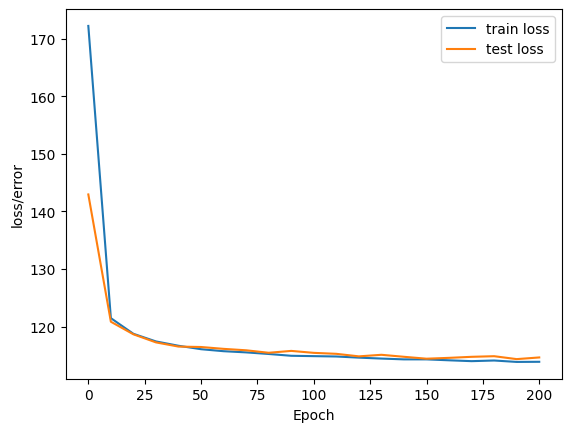

In [ ]:
plt.plot(range(0, iter_max+1, 10), train_losses, label="train loss")
plt.plot(range(0, iter_max+1, 10), test_losses, label="test loss")
plt.ylabel("loss/error")
plt.xlabel('Epoch')
plt.legend()
plt.show()

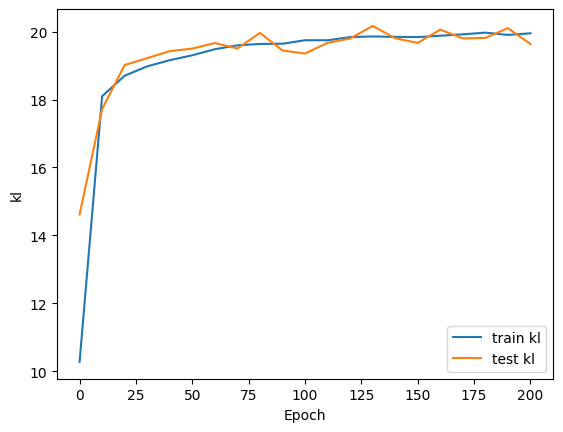

In [ ]:
plt.plot(range(0, iter_max+1, 10), train_kls, label="train kl")
plt.plot(range(0, iter_max+1, 10), test_kls, label="test kl")
plt.ylabel("kl")
plt.xlabel('Epoch')
plt.legend()
plt.show()

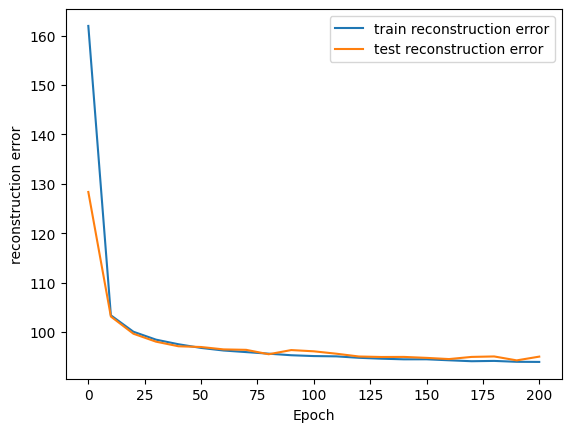

In [ ]:
plt.plot(range(0, iter_max+1, 10), train_recs, label="train reconstruction error")
plt.plot(range(0, iter_max+1, 10), test_recs, label="test reconstruction error")
plt.ylabel("reconstruction error")
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Negative IWAE

##### m = 5

In [ ]:
loss_arr_m5 = []
kl_arr_m5 = []
rec_arr_m5 = []

with torch.no_grad():
  for i in range(50):
      total_loss = 0
      total_kl = 0
      total_rec = 0

      for batch_idx, (xu, _) in enumerate(test_loader):
          xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))

          loss, kl, rec = vae.negative_iwae_bound(xu, 5)
          total_loss +=loss
          total_kl +=kl
          total_rec +=rec


      total_loss = float(total_loss/(batch_idx+1))
      total_kl = float(total_kl/(batch_idx+1))
      total_rec = float(total_kl/(batch_idx+1))

      print("Epoch: ", i+1, "\tLoss: %.3f"% total_loss, "\tKL: %.3f"% total_kl, "\treconstruction loss: %.3f"% total_rec)

      loss_arr_m5.append(total_loss)
      kl_arr_m5.append(total_kl)
      rec_arr_m5.append(total_rec)

Epoch:  1 	Loss: 128.872 	KL: 19.654 	reconstruction loss: 0.197
Epoch:  2 	Loss: 129.052 	KL: 19.643 	reconstruction loss: 0.196
Epoch:  3 	Loss: 129.075 	KL: 19.654 	reconstruction loss: 0.197
Epoch:  4 	Loss: 128.726 	KL: 19.626 	reconstruction loss: 0.196
Epoch:  5 	Loss: 128.852 	KL: 19.625 	reconstruction loss: 0.196
Epoch:  6 	Loss: 128.828 	KL: 19.641 	reconstruction loss: 0.196
Epoch:  7 	Loss: 128.985 	KL: 19.624 	reconstruction loss: 0.196
Epoch:  8 	Loss: 128.612 	KL: 19.642 	reconstruction loss: 0.196
Epoch:  9 	Loss: 128.954 	KL: 19.626 	reconstruction loss: 0.196
Epoch:  10 	Loss: 128.753 	KL: 19.643 	reconstruction loss: 0.196
Epoch:  11 	Loss: 129.252 	KL: 19.645 	reconstruction loss: 0.196
Epoch:  12 	Loss: 129.295 	KL: 19.626 	reconstruction loss: 0.196
Epoch:  13 	Loss: 128.996 	KL: 19.641 	reconstruction loss: 0.196
Epoch:  14 	Loss: 128.958 	KL: 19.631 	reconstruction loss: 0.196
Epoch:  15 	Loss: 128.789 	KL: 19.640 	reconstruction loss: 0.196
Epoch:  16 	Loss: 1

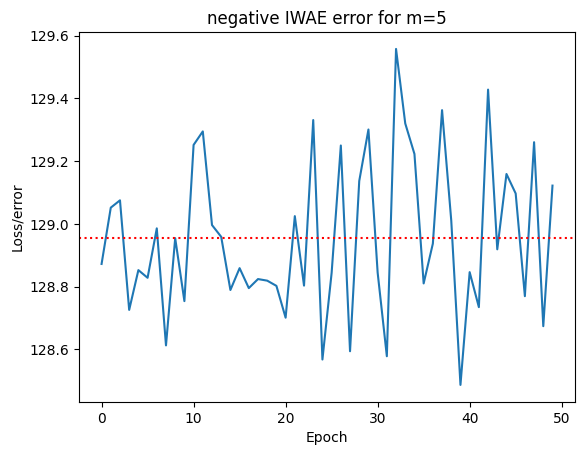

In [ ]:
plt.plot(range(50), loss_arr_m5)
plt.axhline(y = sum(loss_arr_m5)/50, color = 'r', linestyle = 'dotted')
plt.title("negative IWAE error for m=5")
plt.ylabel("Loss/error")
plt.xlabel('Epoch')
plt.show()

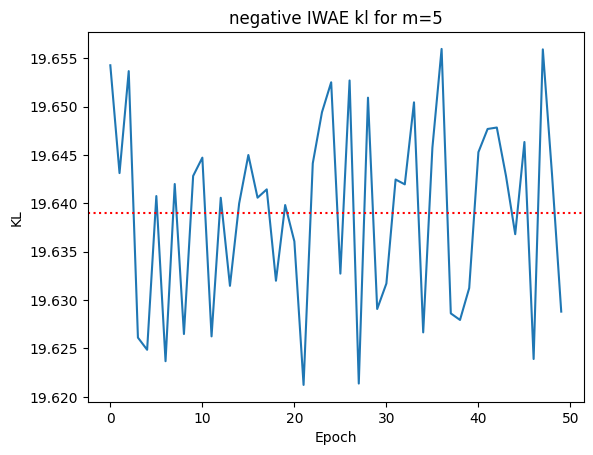

In [ ]:
plt.plot(range(50), kl_arr_m5)
plt.axhline(y = sum(kl_arr_m5)/50, color = 'r', linestyle = 'dotted')
plt.title("negative IWAE kl for m=5")
plt.ylabel("KL")
plt.xlabel('Epoch')
plt.show()

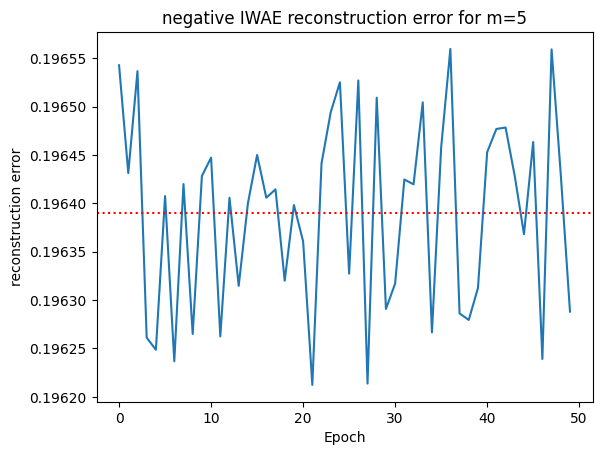

In [ ]:
plt.plot(range(50), rec_arr_m5)
plt.axhline(y = sum(rec_arr_m5)/50, color = 'r', linestyle = 'dotted')
plt.title("negative IWAE reconstruction error for m=5")
plt.ylabel("reconstruction error")
plt.xlabel('Epoch')
plt.show()

##### m = 50

In [ ]:
loss_arr_m50 = []
kl_arr_m50 = []
rec_arr_m50 = []

with torch.no_grad():
  for i in range(50):
      total_loss = 0
      total_kl = 0
      total_rec = 0

      for batch_idx, (xu, _) in enumerate(test_loader):
          xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))

          loss, kl, rec = vae.negative_iwae_bound(xu, 50)
          total_loss +=loss
          total_kl +=kl
          total_rec +=rec

      total_loss = float(total_loss/(batch_idx+1))
      total_kl = float(total_kl/(batch_idx+1))
      total_rec = float(total_kl/(batch_idx+1))

      print("Epoch: ", i+1, "\tLoss: %.3f"% total_loss, "\tKL: %.3f"% total_kl, "\treconstruction loss: %.3f"% total_rec)

      loss_arr_m50.append(total_loss)
      kl_arr_m50.append(total_kl)
      rec_arr_m50.append(total_rec)



Epoch:  1 	Loss: 163.754 	KL: 19.639 	reconstruction loss: 0.196
Epoch:  2 	Loss: 163.299 	KL: 19.624 	reconstruction loss: 0.196
Epoch:  3 	Loss: 163.898 	KL: 19.655 	reconstruction loss: 0.197
Epoch:  4 	Loss: 162.936 	KL: 19.635 	reconstruction loss: 0.196
Epoch:  5 	Loss: 163.440 	KL: 19.635 	reconstruction loss: 0.196
Epoch:  6 	Loss: 163.596 	KL: 19.639 	reconstruction loss: 0.196
Epoch:  7 	Loss: 163.429 	KL: 19.625 	reconstruction loss: 0.196
Epoch:  8 	Loss: 163.351 	KL: 19.631 	reconstruction loss: 0.196
Epoch:  9 	Loss: 163.336 	KL: 19.642 	reconstruction loss: 0.196
Epoch:  10 	Loss: 163.492 	KL: 19.639 	reconstruction loss: 0.196
Epoch:  11 	Loss: 164.052 	KL: 19.625 	reconstruction loss: 0.196
Epoch:  12 	Loss: 164.109 	KL: 19.629 	reconstruction loss: 0.196
Epoch:  13 	Loss: 163.914 	KL: 19.642 	reconstruction loss: 0.196
Epoch:  14 	Loss: 164.009 	KL: 19.624 	reconstruction loss: 0.196
Epoch:  15 	Loss: 163.122 	KL: 19.640 	reconstruction loss: 0.196
Epoch:  16 	Loss: 1

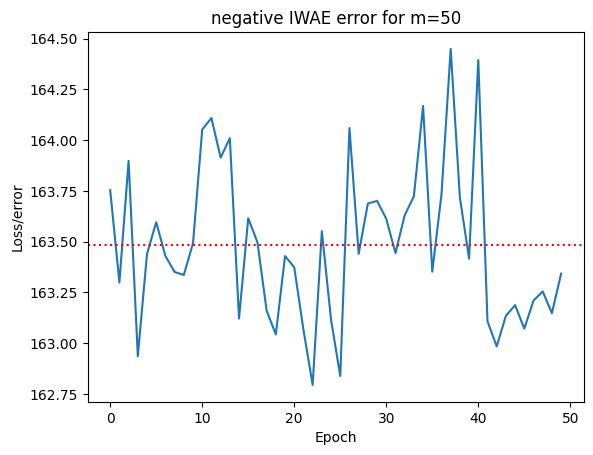

In [ ]:
plt.plot(range(50), loss_arr_m50)
plt.axhline(y = sum(loss_arr_m50)/50, color = 'r', linestyle = 'dotted')
plt.title("negative IWAE error for m=50")
plt.ylabel("Loss/error")
plt.xlabel('Epoch')
plt.show()

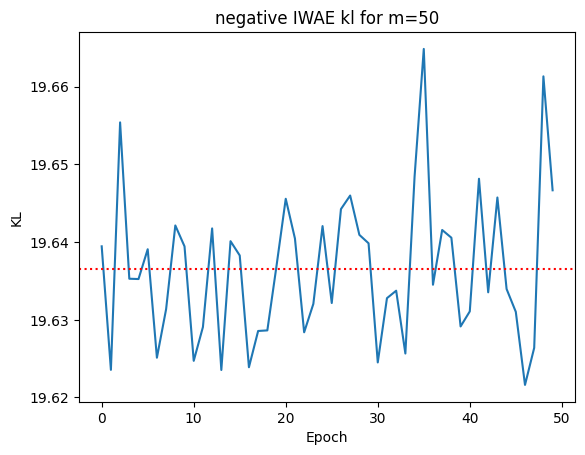

In [ ]:
plt.plot(range(50), kl_arr_m50)
plt.axhline(y = sum(kl_arr_m50)/50, color = 'r', linestyle = 'dotted')
plt.title("negative IWAE kl for m=50")
plt.ylabel("KL")
plt.xlabel('Epoch')
plt.show()

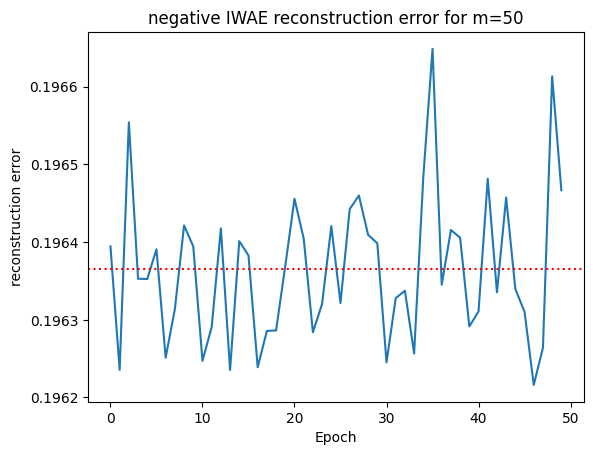

In [ ]:
plt.plot(range(50), rec_arr_m50)
plt.axhline(y = sum(rec_arr_m50)/50, color = 'r', linestyle = 'dotted')
plt.title("negative IWAE reconstruction error for m=50")
plt.ylabel("reconstruction error")
plt.xlabel('Epoch')
plt.show()

##### m = 150

In [ ]:
loss_arr_m150 = []
kl_arr_m150 = []
rec_arr_m150 = []

with torch.no_grad():
  for i in range(50):
      total_loss = 0
      total_kl = 0
      total_rec = 0

      for batch_idx, (xu, _) in enumerate(test_loader):
          xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))

          loss, kl, rec = vae.negative_iwae_bound(xu, 5)
          total_loss +=loss
          total_kl +=kl
          total_rec +=rec

      total_loss = float(total_loss/(batch_idx+1))
      total_kl = float(total_kl/(batch_idx+1))
      total_rec = float(total_kl/(batch_idx+1))

      print("Epoch: ", i+1, "\tLoss: %.3f"% total_loss, "\tKL: %.3f"% total_kl, "\treconstruction loss: %.3f"% total_rec)

      loss_arr_m150.append(total_loss)
      kl_arr_m150.append(total_kl)
      rec_arr_m150.append(total_rec)



Epoch:  1 	Loss: 128.569 	KL: 19.659 	reconstruction loss: 0.197
Epoch:  2 	Loss: 129.311 	KL: 19.645 	reconstruction loss: 0.196
Epoch:  3 	Loss: 128.809 	KL: 19.642 	reconstruction loss: 0.196
Epoch:  4 	Loss: 129.402 	KL: 19.627 	reconstruction loss: 0.196
Epoch:  5 	Loss: 129.039 	KL: 19.645 	reconstruction loss: 0.196
Epoch:  6 	Loss: 129.013 	KL: 19.640 	reconstruction loss: 0.196
Epoch:  7 	Loss: 129.245 	KL: 19.641 	reconstruction loss: 0.196
Epoch:  8 	Loss: 128.895 	KL: 19.633 	reconstruction loss: 0.196
Epoch:  9 	Loss: 128.910 	KL: 19.648 	reconstruction loss: 0.196
Epoch:  10 	Loss: 129.101 	KL: 19.641 	reconstruction loss: 0.196
Epoch:  11 	Loss: 129.517 	KL: 19.648 	reconstruction loss: 0.196
Epoch:  12 	Loss: 128.681 	KL: 19.636 	reconstruction loss: 0.196
Epoch:  13 	Loss: 129.546 	KL: 19.635 	reconstruction loss: 0.196
Epoch:  14 	Loss: 128.645 	KL: 19.617 	reconstruction loss: 0.196
Epoch:  15 	Loss: 128.935 	KL: 19.634 	reconstruction loss: 0.196
Epoch:  16 	Loss: 1

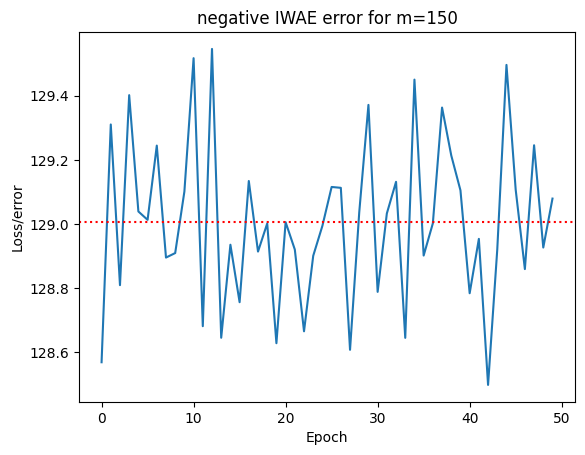

In [ ]:
plt.plot(range(50), loss_arr_m150)
plt.axhline(y = sum(loss_arr_m150)/50, color = 'r', linestyle = 'dotted')
plt.title("negative IWAE error for m=150")
plt.ylabel("Loss/error")
plt.xlabel('Epoch')
plt.show()

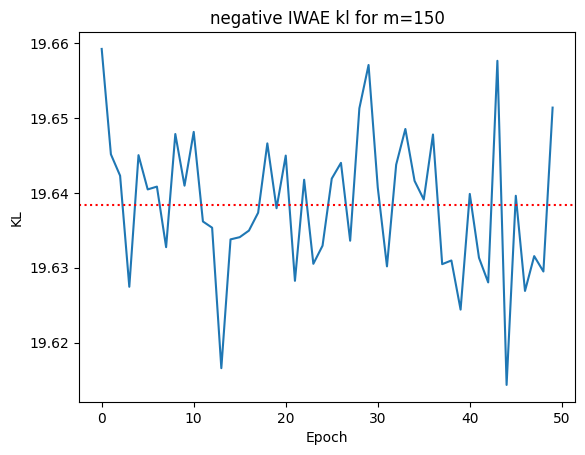

In [ ]:
plt.plot(range(50), kl_arr_m150)
plt.axhline(y = sum(kl_arr_m150)/50, color = 'r', linestyle = 'dotted')
plt.title("negative IWAE kl for m=150")
plt.ylabel("KL")
plt.xlabel('Epoch')
plt.show()

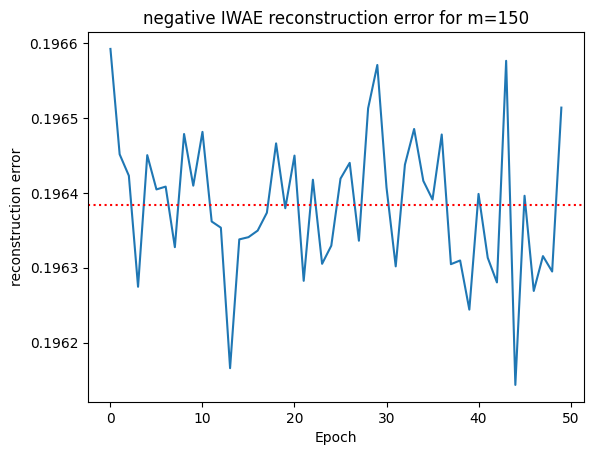

In [ ]:
plt.plot(range(50), rec_arr_m150)
plt.axhline(y = sum(rec_arr_m150)/50, color = 'r', linestyle = 'dotted')
plt.title("negative IWAE reconstruction error for m=150")
plt.ylabel("reconstruction error")
plt.xlabel('Epoch')
plt.show()